## Steps to Implement Naive Approach


1.   Load the Dataset
2.   Data Exploration
3.   Prepare Dataset for Naive Approach
4.   Create Train and Validation set
5.   Define classification model Architecture
6.   Train the model
7.   Make Predictions




## 1. Loading Required Libraries and Dataset

In [ ]:
# Importing Required Libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from skimage.transform import resize

import torch
from torch import nn

In [ ]:
# Fixing a random seed values to stop potential randomness
seed = 42
rng = np.random.RandomState(seed)

In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# unzip the dataset from drive
!unzip /content/drive/My\ Drive/train_zedkk38.zip

Archive:  /content/drive/My Drive/train_zedkk38.zip
   creating: images/
  inflating: images/0.jpg            
  inflating: images/1.jpg            
  inflating: images/10.jpg           
  inflating: images/100.jpg          
  inflating: images/101.jpg          
  inflating: images/102.jpg          
  inflating: images/103.jpg          
  inflating: images/104.jpg          
  inflating: images/105.jpg          
  inflating: images/106.jpg          
  inflating: images/107.jpg          
  inflating: images/108.jpg          
  inflating: images/109.jpg          
  inflating: images/11.jpg           
  inflating: images/110.jpg          
  inflating: images/111.jpg          
  inflating: images/112.jpg          
  inflating: images/113.jpg          
  inflating: images/114.jpg          
  inflating: images/115.jpg          
  inflating: images/116.jpg          
  inflating: images/117.jpg          
  inflating: images/118.jpg          
  inflating: images/119.jpg          
  inflating: im

## 2. Data Exploration

In [ ]:
## Reading target file
data = pd.read_csv('train.csv')
data.shape

(3423, 6)

In [ ]:
data.head()

,image_names,cell_type,xmin,xmax,ymin,ymax
0,1.jpg,RBC,68,165,154,249
1,1.jpg,RBC,1,66,145,260
2,1.jpg,RBC,207,334,160,270
3,1.jpg,RBC,435,540,347,437
4,1.jpg,RBC,535,639,356,464


In [ ]:
data.cell_type.value_counts()

RBC          2909
WBC           262
Platelets     252
Name: cell_type, dtype: int64

In [ ]:
(data.loc[data['cell_type'] =='WBC']).head()

,image_names,cell_type,xmin,xmax,ymin,ymax
17,1.jpg,WBC,247,462,352,480
27,2.jpg,WBC,93,296,1,173
41,4.jpg,WBC,150,337,238,426
55,6.jpg,WBC,244,509,327,480
59,8.jpg,WBC,232,469,102,336


(480, 640, 3)


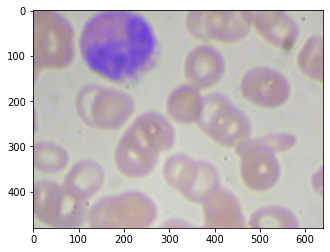

In [ ]:
image = plt.imread('images/' + '2.jpg')
print(image.shape)
plt.imshow(image)

![alt text](https://drive.google.com/uc?export=view&id=1f21F57dToOO0m1SAyHcFq7EUU6Xsb3Mw)

In [ ]:
# creating 4 patches from the image
# format ymin, ymax, xmin, xmax
image_1 = image[0:240, 0:320, :]
image_2 = image[0:240, 320:640, :]

image_3 = image[240:480, 0:320, :]
image_4 = image[240:480, 320:640, :]

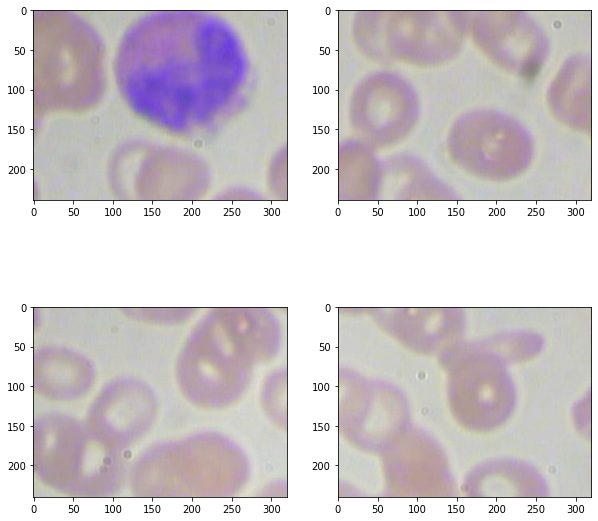

In [ ]:
# visualizing image patches
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
ax[0][0].imshow(image_1)
ax[0][1].imshow(image_2)
ax[1][0].imshow(image_3)
ax[1][1].imshow(image_4)

![alt text](https://drive.google.com/uc?export=view&id=12vGksGb0YVvjokfHvLnt9QBihFysHwUh)

In [ ]:
def iou(box1, box2):

    Irect_xmin, Irect_ymin = max(box1[0],box2[0]), max(box1[2],box2[2])
    Irect_xmax, Irect_ymax = min(box1[1],box2[1]), min(box1[3],box2[3])

    if Irect_xmax < Irect_xmin or Irect_ymax < Irect_ymin:
        target = inter_area = 0
    else: 
      inter_area = np.abs((Irect_xmax - Irect_xmin) * (Irect_ymax - Irect_ymin))
      box1_area = (box1[1]-box1[0])*(box1[3]-box1[2])
      box2_area = (box2[1]-box2[0])*(box2[3]-box2[2])
      union_area = box1_area+box2_area-inter_area

      iou = inter_area/union_area

      target = int(iou > 0.1)
    return target

In [ ]:
box1= [320, 640, 0, 240]
box2= [93,	296, 1, 173]

iou(box1, box2)

0

## 3. Preparing Dataset for Naive Approach

In [ ]:
data.head()

,image_names,cell_type,xmin,xmax,ymin,ymax
0,1.jpg,RBC,68,165,154,249
1,1.jpg,RBC,1,66,145,260
2,1.jpg,RBC,207,334,160,270
3,1.jpg,RBC,435,540,347,437
4,1.jpg,RBC,535,639,356,464


In [ ]:
data['cell_type'] = data['cell_type'].replace({'RBC': 0, 'WBC': 1, 'Platelets': 2})

![alt text](https://drive.google.com/uc?export=view&id=17Jk7u_MoJkN64gQHPfM_AgxoexYjeA4A)

In [ ]:
## keep only Single WBCs
data_wbc = data.loc[data.cell_type == 1].copy()
data_wbc = data_wbc.drop_duplicates(subset=['image_names', 'cell_type'], keep=False)

In [ ]:
# create empty lists
X = []
Y = []

# set patch co-ordinates
patch_1_coordinates = [0, 320, 0, 240]
patch_2_coordinates = [320, 640, 0, 240]
patch_3_coordinates = [0, 320, 240, 480]
patch_4_coordinates = [320, 640, 240, 480]


for idx, row in data_wbc.iterrows():
    # read image
    image = plt.imread('images/' + row.image_names)
    bb_coordinates = [row.xmin, row.xmax, row.ymin, row.ymax]
    
    # extract patches
    patch_1 = image[patch_1_coordinates[2]:patch_1_coordinates[3], patch_1_coordinates[0]:patch_1_coordinates[1], :]
    patch_2 = image[patch_2_coordinates[2]:patch_2_coordinates[3], patch_2_coordinates[0]:patch_2_coordinates[1], :]
    patch_3 = image[patch_3_coordinates[2]:patch_3_coordinates[3], patch_3_coordinates[0]:patch_3_coordinates[1], :]
    patch_4 = image[patch_4_coordinates[2]:patch_4_coordinates[3], patch_4_coordinates[0]:patch_4_coordinates[1], :]

    # set default values
    target_1 = target_2 = target_3 = target_4 = inter_area = 0

    # figure out if the patch contains the object
    ## for patch_1
    target_1 = iou(patch_1_coordinates, bb_coordinates )
      
    ## for patch_2
    target_2 = iou(patch_2_coordinates, bb_coordinates)

    ## for patch_3
    target_3 = iou(patch_3_coordinates, bb_coordinates)

    ## for patch_4
    target_4 = iou(patch_4_coordinates, bb_coordinates)

        
    # resize the patches
    patch_1 = resize(patch_1, (224, 224, 3), preserve_range=True)
    patch_2 = resize(patch_2, (224, 224, 3), preserve_range=True)
    patch_3 = resize(patch_3, (224, 224, 3), preserve_range=True)
    patch_4 = resize(patch_4, (224, 224, 3), preserve_range=True)
    
    # create final input data
    X.extend([patch_1, patch_2, patch_3, patch_4])
    
    # create target data
    Y.extend([target_1, target_2, target_3, target_4])
    
# convert these lists to single numpy array
X = np.array(X)
Y = np.array(Y)

In [ ]:
# 4 patches for every image
data_wbc.shape, X.shape, Y.shape

((240, 6), (960, 224, 224, 3), (960,))

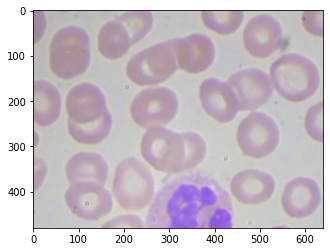

In [ ]:
image = plt.imread('images/' + '1.jpg')

plt.imshow(image)

(<matplotlib.image.AxesImage at 0x7f8da20cfc88>, 0)

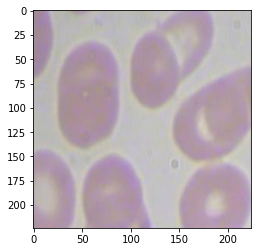

In [ ]:
plt.imshow(X[0].astype('uint8')), Y[0]

## 4. Preparing Train and Validation sets 

In [ ]:
# 4 patches for every image
data_wbc.shape, X.shape, Y.shape

((240, 6), (960, 224, 224, 3), (960,))

In [ ]:
X = np.moveaxis(X, -1, 1) 
X.shape

(960, 3, 224, 224)

In [ ]:
X = X / X.max()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_valid, Y_train, Y_valid=train_test_split(X, Y, test_size=0.1, random_state=seed)
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((864, 3, 224, 224), (96, 3, 224, 224), (864,), (96,))

In [ ]:
X_train = torch.FloatTensor(X_train)
Y_train = torch.FloatTensor(Y_train)

X_valid = torch.FloatTensor(X_valid)
Y_valid = torch.FloatTensor(Y_valid)

## 5. Model Building

In [ ]:
!pip install pytorch-model-summary

In [ ]:
from pytorch_model_summary import summary

In [ ]:
## model architecture
model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2),  
        nn.ReLU(),  
        nn.MaxPool2d(kernel_size=4,stride=2),   
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2),    
        nn.Flatten(),
        nn.Linear(40000, 1),
        nn.Sigmoid()
)

In [ ]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2))
  (4): Flatten()
  (5): Linear(in_features=40000, out_features=1, bias=True)
  (6): Sigmoid()
)


In [ ]:
print(summary(model, X_train[:1]))

-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 64, 110, 110]           4,864           4,864
            ReLU-2     [1, 64, 110, 110]               0               0
       MaxPool2d-3       [1, 64, 54, 54]               0               0
          Conv2d-4       [1, 64, 25, 25]         102,464         102,464
         Flatten-5            [1, 40000]               0               0
          Linear-6                [1, 1]          40,001          40,001
         Sigmoid-7                [1, 1]               0               0
Total params: 147,329
Trainable params: 147,329
Non-trainable params: 0
-------------------------------------------------------------------------


## 6. Train the Model

In [ ]:
## loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
## GPU device
if torch.cuda.is_available():
  model = model.cuda()
  criterion = criterion.cuda()

In [ ]:
# batch size of the model
batch_size = 32

# defining the training phase
model.train()

for epoch in range(15):
    # setting initial loss as 0
    train_loss = 0.0
        
    # to randomly pick the images without replacement in batches
    permutation = torch.randperm(X_train.size()[0])

    # to keep track of training loss
    training_loss = []

    # for loop for training on batches
    for i in range(0,X_train.size()[0], batch_size):
        # taking the indices from randomly generated values
        indices = permutation[i:i+batch_size]

        # getting the images and labels for a batch
        batch_x, batch_y = X_train[indices], Y_train[indices]
        
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda().float(), batch_y.cuda().float()
        
        # clearing all the accumulated gradients
        optimizer.zero_grad()

        # mini batch computation
        outputs = model(batch_x)

        # calculating the loss for a mini batch
        loss = criterion(outputs.squeeze(),batch_y)

        # storing the loss for every mini batch
        training_loss.append(loss.item())

        # calculating the gradients
        loss.backward()

        # updating the parameters
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)

epoch: 	 0 	 training loss: 	 0.8812532115865637
epoch: 	 1 	 training loss: 	 0.4896721221782543
epoch: 	 2 	 training loss: 	 0.3830218580034044
epoch: 	 3 	 training loss: 	 0.2965985282703682
epoch: 	 4 	 training loss: 	 0.22580521608944293
epoch: 	 5 	 training loss: 	 0.2956858895443104
epoch: 	 6 	 training loss: 	 0.25800157090028125
epoch: 	 7 	 training loss: 	 0.19872794162344048
epoch: 	 8 	 training loss: 	 0.15109274867508146
epoch: 	 9 	 training loss: 	 0.1291662206252416
epoch: 	 10 	 training loss: 	 0.1239649919724023
epoch: 	 11 	 training loss: 	 0.12035426235309353
epoch: 	 12 	 training loss: 	 0.17079515903498288
epoch: 	 13 	 training loss: 	 0.1303901297074777
epoch: 	 14 	 training loss: 	 0.11920478777890955


## 7. Make predictions

In [ ]:
output = model(X_valid[:5].to('cuda')).cpu().detach().numpy()

In [ ]:
output

array([[0.00641595],
       [0.01172841],
       [0.99919134],
       [0.01065345],
       [0.00520921]], dtype=float32)

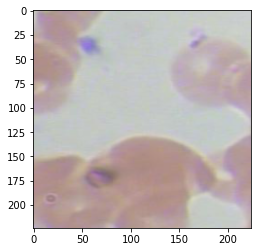

In [ ]:
plt.imshow(np.transpose(X_valid[1])) 